In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

In [2]:
import pickle

with open("/home/bruce1996/nvme2/scRNA/GSE149614_overall_normalized.pkl",'rb') as f :
    scRNA_exp_m = pickle.load(f)
f.close()

with open("/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/ensembl2hgnc.pkl",'rb') as f :
    tmp = pickle.load(f)
f.close()
hgnc2ens = {}
for ens,hgnc in tmp.items() :
    if isinstance(hgnc,str) :
        hgnc2ens[hgnc] = ens
ens2hgnc = {v:key for key,v in hgnc2ens.items()}
metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)

In [3]:
idx = metadata.index[np.where((metadata['Celltype'] == 'Hepatocyte') & (metadata['site'] == 'Tumor'),True,False)]
exp_m = scRNA_exp_m.loc[:,idx]
metadata = metadata.loc[idx,:]

del scRNA_exp_m
coding_gene = set(exp_m.index).intersection(hgnc2ens.keys())
coding_m = exp_m.loc[coding_gene,:]
coding_m.index = [hgnc2ens[x] for x in coding_m.index]

In [4]:
with open("/home/bruce1996/nvme2/scRNA/GSE149614_coding_gene_hepatocyte_normalized.pkl",'wb') as f :
    pickle.dump(coding_m,f)
f.close()

In [5]:
vote = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/ensemble_learning_result/ensemble_hbv_only_np_ratio_35_vote_result.txt",sep='\t',index_col=0)
voted_gene = list(set(vote.index[vote['Vote'] > 0]).intersection(coding_m.index))
voted_exp_m = coding_m.loc[voted_gene,:]

### PCA scatter plot

In [10]:
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
idx = metadata['Advance_celltype'] != 'cholangiocyte '
sample = metadata.index[idx]
x = voted_exp_m.loc[:,sample].T

scaler = StandardScaler()
std_x = scaler.fit_transform(x.to_numpy())
pca = PCA(n_components=2)
pca_result = pca.fit_transform(std_x)
plot_df = pd.DataFrame({'PC1' : pca_result[:,0],'PC2' : pca_result[:,1],
                        'Virus' : metadata.loc[sample,'virus']},index=sample)
plt.figure(figsize=(12,8))
sns.scatterplot(data = plot_df,x='PC1',y='PC2',hue='Virus',palette='Set2')
plt.xlabel("PC1({:.2f}%)".format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel("PC2({:.2f}%)".format(100 * pca.explained_variance_ratio_[1]))
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/predict_celltype_xgb/overall_hepatocyte_standardized_pca.png",dpi=300,bbox_inches='tight')

In [ ]:
reducer = UMAP(n_jobs=32)
embedding = reducer.fit_transform(std_x)
plot_df = pd.DataFrame({'UMAP1' : embedding[:,0],'UMAP2' : embedding[:,1],
                        'stage' : metadata.loc[sample,'stage']},index=sample)
plt.figure(figsize=(12,8))
sns.scatterplot(data = plot_df,x='UMAP1',y='UMAP2',hue='stage',palette='Set2')
#plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/predict_celltype_xgb/overall_hepatocyte_standardized_umap.png",dpi=300,bbox_inches='tight')

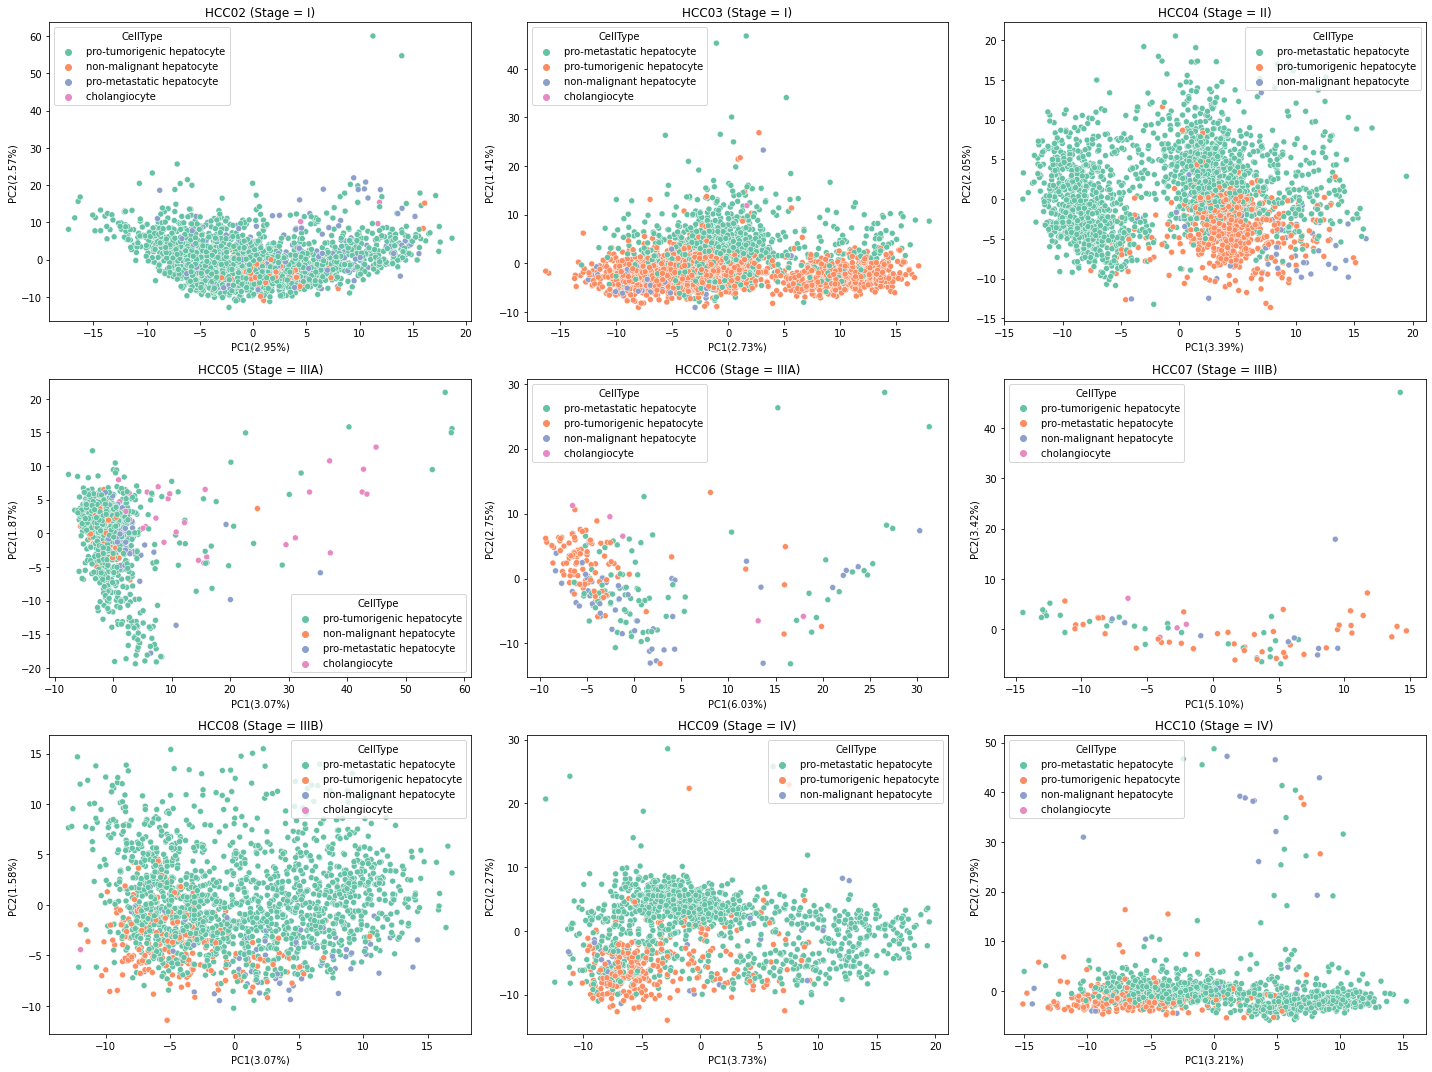

In [27]:
idx = metadata['Advance_celltype'] != 'cholangiocyte '
patients = list(sorted(metadata['patient'].unique()))
patient_stage = dict(zip(metadata['patient'],metadata['stage']))
fig,axes = plt.subplots(3,3,figsize=(20,15))
axs = axes.ravel()
for idx,p in enumerate(patients[1:]) :
    samples = metadata.index[metadata['patient'] == p]
    x = voted_exp_m.loc[:,samples].T

    scaler = StandardScaler()
    std_x = scaler.fit_transform(x.to_numpy())
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(std_x)
    plot_df = pd.DataFrame({'PC1' : pca_result[:,0],'PC2' : pca_result[:,1],
                            'CellType' : metadata['Advance_celltype'][samples]},index=samples)
    sns.scatterplot(data = plot_df,x='PC1',y='PC2',hue='CellType',palette='Set2',ax=axs[idx])
    axs[idx].set_title(p + ' (Stage = %s)' % patient_stage[p])
    axs[idx].set_xlabel("PC1({:.2f}%)".format(100 * pca.explained_variance_ratio_[0]))
    axs[idx].set_ylabel("PC2({:.2f}%)".format(100 * pca.explained_variance_ratio_[1]))
plt.tight_layout()
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/predict_celltype_xgb/patient_hepatocyte_standardized_pca.png",dpi=300,bbox_inches='tight')

### Celltype classification by XGBoost

In [5]:
from xgboost import cv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score,recall_score

def sklearn_precision(predict,dtrain : xgb.DMatrix):
    labels = dtrain.get_label()
    return "precision", precision_score(predict,labels,average='micro')

def sklearn_recall(predict,dtrain : xgb.DMatrix):
    labels = dtrain.get_label()
    return "recall", recall_score(predict,labels,average='micro')

cell2int = {'non-malignant hepatocyte':0,'pro-tumorigenic hepatocyte':1,'pro-metastatic hepatocyte':2}
idx = metadata['Advance_celltype'] != 'cholangiocyte '
xgb_metadata = metadata.loc[idx,:]
xgb_exp_m = voted_exp_m.loc[:,idx]
y = xgb_metadata['Advance_celltype'].replace(cell2int)
# predict celltype in each patient
patients = sorted(list(xgb_metadata['patient'].unique()))
patient_xgb = {}
# xgb parameter
xgb_params = {"objective":"multi:softmax","n_estimators" : 1000,'max_depth': 5,'nthread' : 32,'num_class' : 3,
              'eval_metric' : 'precision,recall,f1_score'}
for p in patients :
    x = xgb_exp_m.loc[:,xgb_metadata['patient'] == p].T
    patient_y = y[xgb_metadata['patient'] == p]
    ### standardization
    scaler = StandardScaler()
    std_x = scaler.fit_transform(x)
    
    dmatrix = xgb.DMatrix(data=std_x,label=patient_y)
    xgb_cv = cv(dtrain=dmatrix, params=xgb_params, nfold=10,
                    num_boost_round=10, metrics=["auc","aucpr"],stratified=True, as_pandas=True,custom_metric=sklearn_precision)
    patient_xgb[p] = xgb_cv
    xgb_cv.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/predict_celltype_xgb/xgb_metric_%s.txt" % p, sep='\t')

/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


[09:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:05] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negativ

/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


[09:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:14] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[09:52:14] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negativ

/home/bruce1996/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


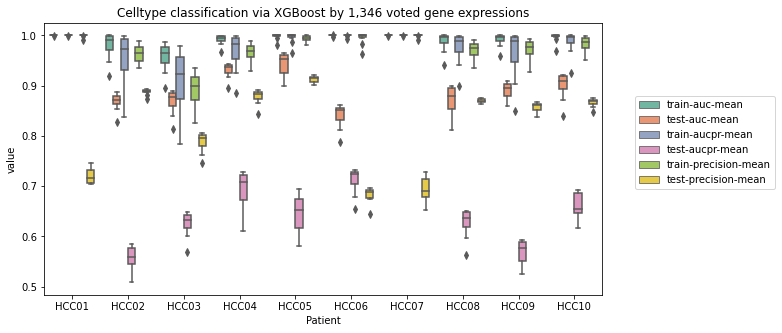

In [8]:
patient_xgb_cv = pd.DataFrame()
for p in patients :
    xgb_cv = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/predict_celltype_xgb/xgb_metric_%s.txt" % p, sep='\t',index_col=0)
    df = xgb_cv.melt()
    df['Patient'] = [p] * df.shape[0]
    patient_xgb_cv = pd.concat([patient_xgb_cv,df])

metric = ['train-auc-mean', 'test-auc-mean','train-aucpr-mean','test-aucpr-mean', 'train-precision-mean', 'test-precision-mean']
idx = [x in metric for x in patient_xgb_cv['variable']]
plot_df = patient_xgb_cv.loc[idx,:]
plot_df.rename(columns={'variable' : 'Metric'},inplace=True)

plt.figure(figsize=(10,5))
sns.boxplot(data=plot_df,x='Patient',y='value',hue='Metric',palette='Set2',hue_order = metric)
plt.title("Celltype classification via XGBoost by 1,346 voted gene expressions")
plt.legend(bbox_to_anchor=(1.05,0.75))
#plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/predict_celltype_xgb/xgb_10fold_cv_performance.png",dpi=300,bbox_inches='tight')

### Report celltype from multiple xgboost model

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score
from xgboost import XGBClassifier

In [7]:
#remove cholangiocyte
samples = metadata.index[np.where(metadata['Advance_celltype'] != 'cholangiocyte ',True,False)]
voted_exp_m = voted_exp_m.loc[:,samples]
metadata = metadata.loc[samples,:]

In [8]:
patients = sorted(metadata['patient'].unique())
cell2int = {'non-malignant hepatocyte':0,'pro-tumorigenic hepatocyte':1,'pro-metastatic hepatocyte':2}
patient_xgb = {p:{} for p in patients}

for p in patients :
    p_idx = metadata.index[np.where(metadata['patient'] == p,True,False)]
    patient_m = voted_exp_m.loc[:,p_idx].T.to_numpy()
    y = metadata.loc[p_idx,'Advance_celltype'].replace(cell2int).values

    scaler = StandardScaler()
    std_x = scaler.fit_transform(patient_m)
    x_train, x_test, y_train, y_test = train_test_split(std_x,y,test_size=0.2,stratify=y)

    xgboostModel = XGBClassifier(n_estimators=100, learning_rate= 0.3,objective="multi:softmax",nthread=32)
    xgboostModel.fit(x_train, y_train)
    y_pred = xgboostModel.predict(x_test)
    patient_xgb[p]['Model'] = xgboostModel
    patient_xgb[p]['x'] = std_x
    patient_xgb[p]['y'] = y
    patient_xgb[p]['Recall'] = recall_score(y_test,y_pred,average='weighted')
    patient_xgb[p]['Precision'] = precision_score(y_test,y_pred,average='weighted')
    

/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn

In [9]:
patients = list(patient_xgb.keys())
for test_p in patients :
    n_sample = patient_xgb[test_p]['x'].shape[0]
    print("The number of %d samples in patient : %s" % (n_sample,test_p))
    patient_xgb[test_p]['prediction_result'] = {}
    for celltype,celltype_idx in cell2int.items() :
        n_sample = sum(np.where(patient_xgb[test_p]['y'] == celltype_idx,True,False))
        patient_xgb[test_p]['prediction_result'][celltype] = np.zeros([n_sample,10])
    for idx,predict_p in enumerate(patients):
        if predict_p == test_p :
            continue
        else :
            model = patient_xgb[predict_p]['Model']
            y_pred = model.predict(patient_xgb[test_p]['x'])
            for celltype,celltype_idx in cell2int.items() :
                sample_idx = np.where(patient_xgb[test_p]['y'] == celltype_idx,True,False)
                patient_xgb[test_p]['prediction_result'][celltype][:,idx] = y_pred[sample_idx]

The number of 71 samples in patient : HCC01
The number of 2154 samples in patient : HCC02
The number of 3470 samples in patient : HCC03
The number of 2454 samples in patient : HCC04
The number of 1194 samples in patient : HCC05
The number of 234 samples in patient : HCC06
The number of 81 samples in patient : HCC07
The number of 1840 samples in patient : HCC08
The number of 1489 samples in patient : HCC09
The number of 1164 samples in patient : HCC10


### Visualization XGBoost prediction result

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
plot_df = pd.DataFrame()
for celltype,idx in cell2int.items() :
    for test_p in patients :
        tmp = pd.DataFrame(patient_xgb[test_p]['prediction_result'][celltype],columns=patients)
        tmp.drop([test_p],axis=1,inplace=True)
        prob = tmp.apply(lambda x : sum(x == idx) / 9,axis=1).values
        n_samples = len(prob)
        df = pd.DataFrame({'Test' : test_p,'Prob' : prob,'Celltype' : celltype})
        plot_df = pd.concat([plot_df,df])

plt.figure(figsize=(20,5))
sns.boxplot(data=plot_df,x='Test',y='Prob',hue='Celltype',palette='Set3',showfliers=False)
plt.ylabel('Predicted proability')
plt.legend(bbox_to_anchor=(1.02, 0.8),title="Celltype")
plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/predict_celltype_xgb/celltype_predicted_prob_boxplot.png",dpi=300,bbox_inches='tight')

In [ ]:
for celltype,idx in cell2int.items():
    precision_m = pd.DataFrame(np.zeros([10,10]),index=patients,columns=patients)
    recall_m = pd.DataFrame(np.zeros([10,10]),index=patients,columns=patients)
    for predict in patients :
        for test in patients :
            sample_idx = np.where(patient_xgb[test]['y'] == idx,True,False)
            y_pred = patient_xgb[predict]['Model'].predict(patient_xgb[test]['x'][sample_idx,:])
            y_true = patient_xgb[test]['y'][sample_idx]
            precision_m.loc[predict,test] = precision_score(y_pred,y_true,average='weighted')
            recall_m.loc[predict,test] = recall_score(y_pred,y_true,average='weighted')
    metric_d = {'Precision' : precision_m,'Recall' : recall_m}
    for metric in metric_d :
        matrix = metric_d[metric]
        plt.figure(figsize=(10,7))
        p = sns.heatmap(matrix,annot=True,fmt="0.2f",cmap='YlGnBu_r')
        p.set_yticklabels(p.get_yticklabels(),rotation=0)
        plt.ylabel("Predict",fontsize=12,fontfamily='monospace')
        plt.xlabel("Test",fontsize=12,fontfamily='monospace')
        plt.title("%s %s matrix" % (celltype,metric),fontsize=15,fontfamily='monospace')
        plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/predict_celltype_xgb/%s_%s_matrix.png" % (celltype.replace(' ','_'),metric.lower()),dpi=300,bbox_inches='tight')